# Fractional Cover Custom Statistics

| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | August 10, 2018 |

__Background:__ The code snippets in this notebook will let you retrieve and plot the [Fractional Cover](https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF) (FC25) data stored in DEA.
More information on *Fractional Cover* can be found in the *'Introduction to Fractional Cover'* notebook.

__What does this notebook do?:__ This notebook demonstrates using Fractional Cover Percentiles (calculated using datacube stats).The data is then saved to NetCDF and GeoTIFF for analysis elsewhere.

### Fractional Cover Bands: [[1](#References)]

- **Bare Soil (bare ground, rock, disturbed) (BS):**  - Bare Ground (bare soil, rock) percentage; Digital Number 10000 = 100%

- **Photosythetic Vegetation. (green grass, trees, etc.) (PV):**  - Photosynthetic Vegetation: Green Vegetation percentage;Digital Number 10000 = 100%

- **Non-Photosythetic vegetation (litter, dead leaf and branches) (NPV):** - Non-Photosynthetic Vegetation (litter, dead leaves andbranches) percentage; Digital Number 10000 = 100%

- **Unmixing Error (UE):**  - Unmixing Error. The residual error, defined as the Euclidean Norm of the Residual Vector. High values express less confidence in the fractional components.
    
__No Data Values:__ Fractional cover contains no data values (-1)
we use the datacube storage function "masking.mask_invalid_data" to remove these from our data before using the data

### Limitations, Errors and Uncertainty:

__Water and soil moisture:__
Pixels over water may show incorrect values for Photosynthetic Vegetation. [[1](#References)] Water should be masked out, maybe by using WOfS or a water index. Soil moisture may affect the accuracy of the product [[1](#References)]. 

__Sums greater than 100%:__
"Occasionally the sum of the three components is not equal to 100%. Differences are usually small and are not rounded in order to preserve what may be useful seasonal indicators. "[[1](#References)]

__Similarity between Bare Soil and NPV:__
Model can perform badly on pixels where bare soil and NPV endmembers are similar. [[1](#References)]

__Compared to field data:__
"Based on the comparison with the field data the FC25 product has an overall Root Mean Squared Error (RMSE) of 11.8%. The error margins vary for the three different layers: green RMSE: 11.0%, non-green RMSE: 17.4% and bare RMSE: 12.5%" [[1](#References)]


## Import modules from standard libraries, datacube and files
Select 'Trust this notebook' to import these modules.

In [44]:
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

#modules for datacube
import datacube
from datacube.storage import masking
from datacube.storage.storage import write_dataset_to_netcdf
from datacube_stats.statistics import Percentile
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser ## this is the group_by for wofs! 
# Import external functions from dea-notebooks --note Scripts directory has moved recently
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/'))
import DEAPlotting, DEADataHandling

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-FC')

### Specify the *query* with the coordinates and date range

In [4]:
#the query is a dictionary where the keys are the spatio-temporal specs
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time':('2015-01-01', '2017-01-31')
        }

## load the data according to our query


In [5]:
ds = DEADataHandling.load_clearlandsat(dc, query,product='fc')

Loading ls5 PQ
    Skipping ls5
Loading ls7 PQ
    Loading 0 filtered ls7 timesteps
Loading ls8 PQ
    Loading 15 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


### Plot Fractional Cover and Unmixing Error Bands
Note that Unmixing Error is high over water

In [6]:
#just a scene we want to plot - this can be done other ways
scene = 0

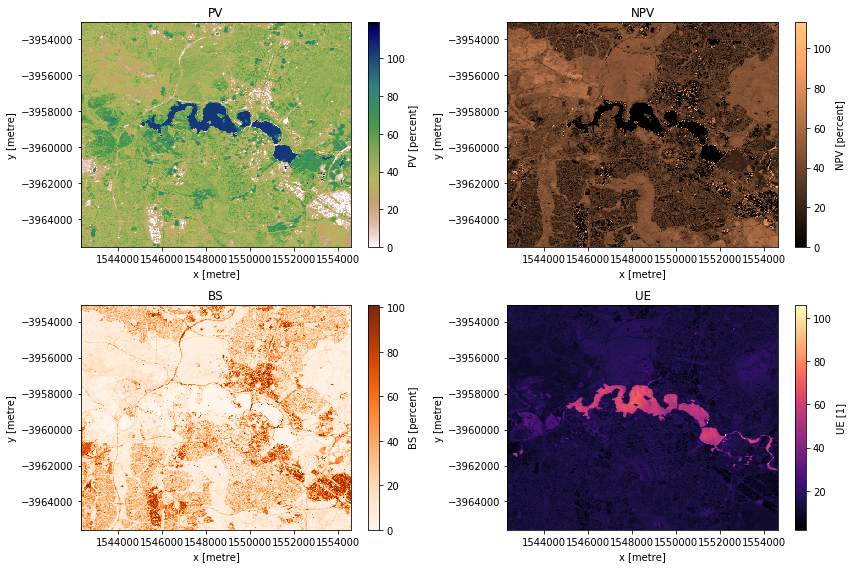

In [7]:
#set up our images on a grid using gridspec
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
ds.PV.isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
ds.BS.isel(time=scene).plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
ds.NPV.isel(time=scene).plot(cmap='copper')
ax3.set_title('NPV')

ax4=plt.subplot(gs[1,1])
ds.UE.isel(time=scene).plot(cmap='magma')
ax4.set_title('UE')

plt.tight_layout()
plt.show()

### load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'

In [23]:
#load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'
wofls = dc.load(product = 'wofs_albers', like=ds, group_by='solar_day', fuse_func=wofs_fuser)

In [25]:
wofls

<xarray.Dataset>
Dimensions:  (time: 134, x: 492, y: 500)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-02T23:50:19.500000 ...
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    water    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    crs:      EPSG:3577

## Remove areas of water from the Fractional Cover dataset

In [9]:
wetwofl = masking.make_mask(wofls, wet=True)
#match WOFL times to our fractional cover times
unwofld = ds.where(ds.time == wetwofl.time)
#mask out water from fractional cover
unwofld = unwofld.where(wetwofl.water==False, drop=False)

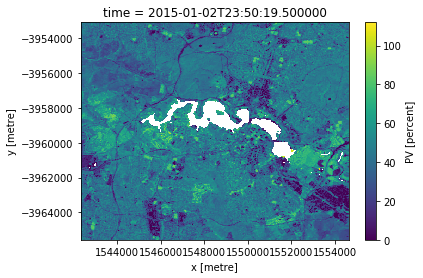

In [12]:
unwofld.isel(time=0).PV.plot()

## drop scenes where all values are nans
- to deal with a bug in numpy quantiles for multiple quantiles that doesn't handle all-nan slices correctly

In [10]:
#unwofld =unwofld.dropna(dim='time', how='all')

## Calculate quantiles of Fractional Cover

### Select quantiles to calculate

In [14]:
#edit this list if you want different qantiles
quantiles = [0, 0.05, 0.2, 0.5, 0.8, 0.95, 1]

## Calculate quantiles

In [3]:
#FC_quantiles =argpercentile(   quantiles, dim='time', keep_attrs=True)

In [26]:
ds

<xarray.Dataset>
Dimensions:    (time: 15, x: 492, y: 500)
Coordinates:
  * y          (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x          (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
  * time       (time) datetime64[ns] 2015-01-02T23:50:19.500000 ...
Data variables:
    BS         (time, y, x) float64 18.0 25.0 31.0 28.0 32.0 31.0 27.0 26.0 ...
    PV         (time, y, x) float64 45.0 45.0 46.0 53.0 50.0 48.0 54.0 51.0 ...
    NPV        (time, y, x) float64 36.0 29.0 22.0 19.0 17.0 21.0 19.0 21.0 ...
    UE         (time, y, x) float64 16.0 16.0 14.0 13.0 12.0 11.0 12.0 14.0 ...
    data_perc  (time) float64 1.0 0.9952 0.9998 0.9997 0.9997 0.9998 1.0 1.0 ...
Attributes:
    crs:      EPSG:3577

In [27]:
unwofld

<xarray.Dataset>
Dimensions:    (time: 15, x: 492, y: 500)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-02T23:50:19.500000 ...
  * y          (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x          (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    BS         (time, y, x) float64 18.0 25.0 31.0 28.0 32.0 31.0 27.0 26.0 ...
    PV         (time, y, x) float64 45.0 45.0 46.0 53.0 50.0 48.0 54.0 51.0 ...
    NPV        (time, y, x) float64 36.0 29.0 22.0 19.0 17.0 21.0 19.0 21.0 ...
    UE         (time, y, x) float64 16.0 16.0 14.0 13.0 12.0 11.0 12.0 14.0 ...
    data_perc  (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
Attributes:
    crs:      EPSG:3577

In [60]:
FC_quantiles =Percentile(unwofld)   

In [61]:
FC_quantiles.

## Plot quantiles 

In [ ]:
FC_quantiles.PV.plot(col='quantile', cmap='YlGn', vmax=100)
FC_quantiles.NPV.plot(col='quantile', cmap='copper', vmax=100)
FC_quantiles.BS.plot(col='quantile', cmap='Oranges_r', vmax=100)

### Edit save file path to choose where to save your output files

In [ ]:
#save files to your home directory (add your outpath here if you want to change it)
savefilepath = os.path.expanduser('~/')

## Save Fractional Cover quantiles to NetCDF
 - add a unit to the unitless dimension so that it writes to NetCDF

In [ ]:
FC_quantiles['quantile'].attrs['units'] = 'quantile_unit'

## Write out quantiles to NetCDF

In [ ]:
try:
    for quant in range (0,len(quantiles)):
        DEADataHandling.write_your_netcdf(FC_quantiles.isel(quantile=quant), 'FC_Q'+str(quantiles[quant]), savefilepath+'FC_Q_'+(str(quantiles[quant]).replace('.','_'))+'.nc', crs = ds.crs)
# #complain if the file already exists but don't fail    
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))
print('wrote to netCDF' )

## Save Fractional Cover scenes to NetCDF
- 'data_perc' has no units and therefore doesn't write to netcdf

In [ ]:
unwofld.drop('data_perc')

In [ ]:
try:
    DEADataHandling.write_your_netcdf(unwofld, 'FC25', savefilepath+'FC25'+'.nc', crs = ds.crs)
#complain if the file already exists but don't fail    
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))
print('wrote to netCDF' )

## Save Fractional Cover scenes to GeoTIFF


In [ ]:
ds = unwofld
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    #drop the time dimension for only one timestep
    #write the dataset without the data percentage to file
    ds1 = ds.squeeze()
    ds1 = ds1.drop('data_perc')
    write_geotiff(savefilepath+'FC25_'+'.tif', ds1)

elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        try:
            write_geotiff(savefilepath+'FC25_'+str(timestep)+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

## Save Fractional Cover quantiles to GeoTiff

In [ ]:
try:
    for quant in range (0,len(quantiles)):
        ds = FC_quantiles.isel(quantile=quant)
        #print(ds)
# #write a geotiff to file for each timestep
# ds1 = ds.squeeze()
# ds1 = ds1.drop('data_perc')
        write_geotiff(savefilepath+'FC_Q_'+(str(quantiles[quant]).replace('.','_'))+'.tif', ds)
        print('wrote to GeoTiff' )
#         DEADataHandling.write_your_netcdf(FC_quantiles.isel(quantile=quant), 'FC_Q'+str(quantiles[quant]), savefilepath+'FC_Q_'+(str(quantiles[quant]).replace('.','_'))+'.nc', crs = ds.crs)
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))

## References
1. GA, 2015. *Fractional Cover (FC25) Product Description.* https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF

2. TERN Auscover, 2012. *Fractional cover - Landsat, Joint Remote Sensing Research Program algorithm, Australia coverage.* Last modified by Peter Scarth on 2017/03/24 09:53. http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Fractional+Cover